In [ ]:
import tensorflow as tf
import numpy as np
import keras
from tensorflow.keras.applications import ResNet50V2,VGG16
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Nadam
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import zipfile

In [ ]:
#Unzip

zip_path = "/content/archive (6).zip"
extract_path = "/content/extracted_folder"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Path to the extracted dataset
data_path = '/content/extracted_folder/Training'
categories = os.listdir(data_path)
categories = sorted(os.listdir(data_path))
labels = [i for i in range(len(categories))]
label_dict={}
for index in range(len(categories)):
  label_dict[categories[index]]=labels[index]
print(categories)
print(labels)
print(label_dict)

['0Normal', '1Doubtful', '2Mild', '3Moderate', '4Severe']
[0, 1, 2, 3, 4]
{'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}


In [ ]:
# Increase image size for better feature extraction
img_size = 224  # Standard size for ResNet

In [ ]:
# Data loading with preprocessing
data = []
label = []

for category in categories:
    folder_path = os.path.join(data_path, category)

    img_names = os.listdir(folder_path)


    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            # Preserve color information as knee X-rays often have relevant color features
            resized = cv2.resize(img, (img_size, img_size))
            # Apply CLAHE for better contrast
            if len(resized.shape) > 2:
                lab = cv2.cvtColor(resized, cv2.COLOR_BGR2LAB)
                l, a, b = cv2.split(lab)
                clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
                cl = clahe.apply(l)
                limg = cv2.merge((cl, a, b))
                enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
                data.append(enhanced_img)
            else:
                clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
                enhanced_img = clahe.apply(resized)
                data.append(enhanced_img)
            label.append(label_dict[category])
        except Exception as e:
            print('Exception:', e)

In [ ]:
# Convert to numpy arrays
data = np.array(data)/255.0
label = np.array(label)

# Print the shape to verify
print("Data shape:", data.shape)


Data shape: (1650, 224, 224, 3)


In [ ]:

# One-hot encode the labels
from keras.utils import to_categorical
new_label = to_categorical(label)
print("Label shape:", new_label.shape)

Label shape: (1650, 5)


In [ ]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42, stratify=label)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator()

In [ ]:

# Create augmented data generators
train_generator = train_datagen.flow(
    x_train, y_train,
    batch_size=32)

validation_generator = validation_datagen.flow(
    x_test, y_test,
    batch_size=32)

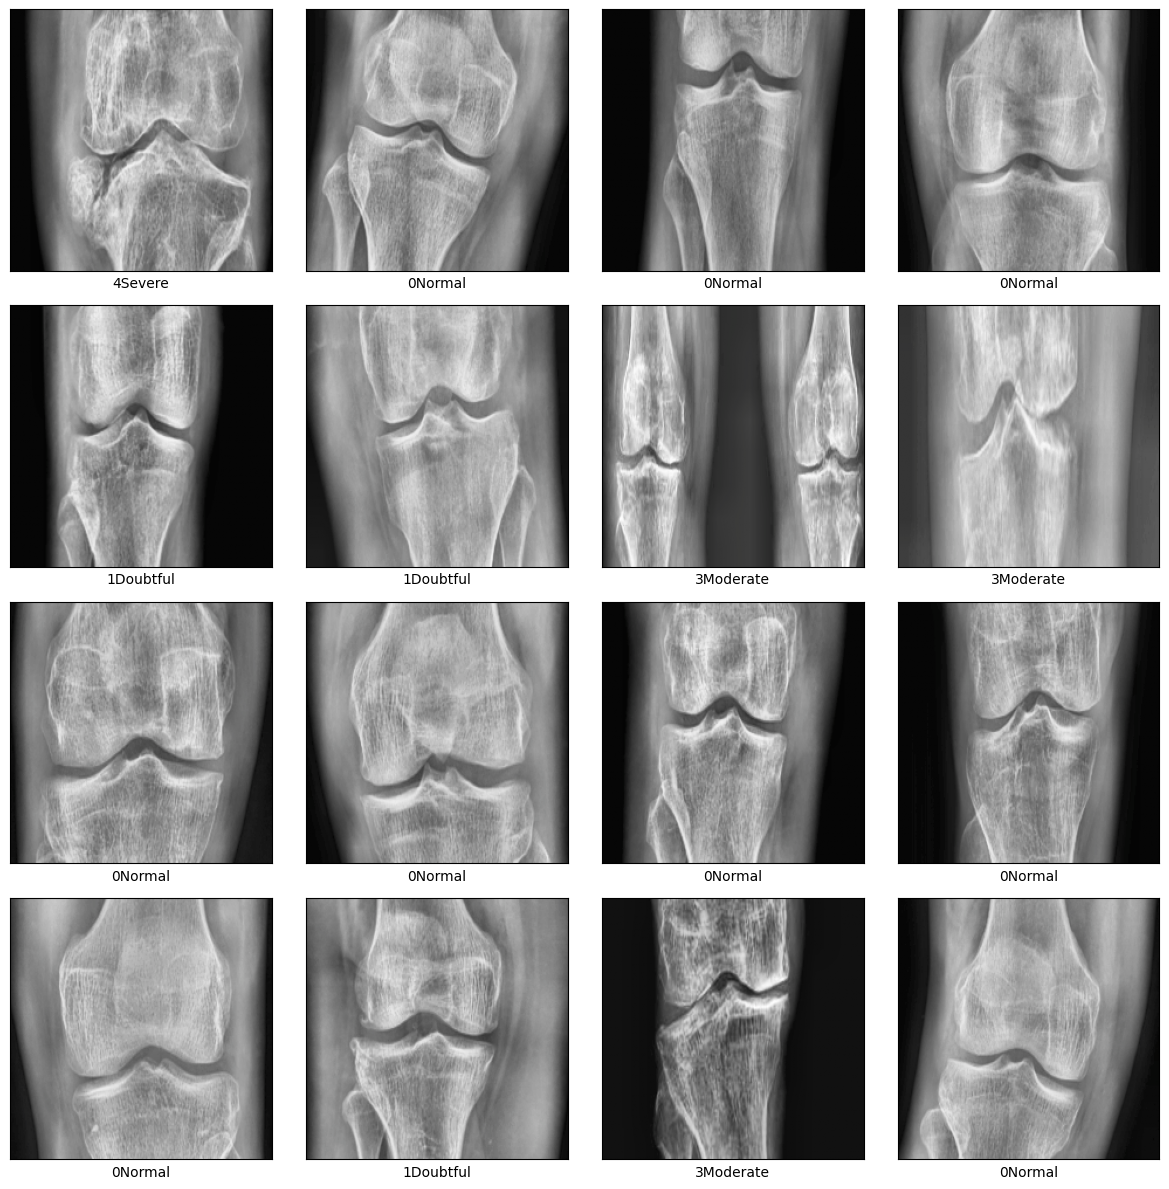

In [ ]:
# Visualize some samples
plt.figure(figsize=(12, 12))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.tight_layout()
plt.savefig('sample_images.png')
plt.show()

In [ ]:
# Use transfer learning with pre-trained model
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile with a lower learning rate
nadam = Nadam(learning_rate=0.001)
model.compile(optimizer=nadam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 24,746,501 (94.40 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:

# Add callbacks to improve training
checkpoint = ModelCheckpoint(
    'knee_model_best.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot back to class indices
y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convert to dictionary (Keras expects this format)
class_weights_dict = dict(enumerate(class_weights))
# Train the model

history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 32,
    callbacks=callbacks,class_weight=class_weights_dict
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.3021 - loss: 1.7373
Epoch 1: val_accuracy improved from -inf to 0.50313, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 643ms/step - accuracy: 0.3031 - loss: 1.7340 - val_accuracy: 0.5031 - val_loss: 1.1362 - learning_rate: 0.0010
Epoch 2/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.3438 - loss: 1.6798

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.50313
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.3438 - loss: 1.6798 - val_accuracy: 0.4625 - val_loss: 1.1555 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.4379 - loss: 1.3257
Epoch 3: val_accuracy improved from 0.50313 to 0.55313, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 518ms/step - accuracy: 0.4383 - loss: 1.3248 - val_accuracy: 0.5531 - val_loss: 1.0009 - learning_rate: 0.0010
Epoch 4/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.4375 - loss: 1.3701
Epoch 4: val_accuracy improved from 0.55313 to 0.55625, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4375 - loss: 1.3701 - val_accuracy: 0.5562 - val_loss: 1.0016 - learning_rate: 0.0010
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4943 - loss: 1.2343
Epoch 5: val_accuracy improved from 0.55625 to 0.59688, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 397ms/step - accuracy: 0.4941 - loss: 1.2343 - val_accuracy: 0.5969 - val_loss: 0.9548 - learning_rate: 0.0010
Epoch 6/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6562 - loss: 0.8798
Epoch 6: val_accuracy did not improve from 0.59688
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6562 - loss: 0.8798 - val_accuracy: 0.5906 - val_loss: 0.9682 - learning_rate: 0.0010
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4815 - loss: 1.2069
Epoch 7: val_accuracy did not improve from 0.59688
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.4815 - loss: 1.2068 - val_accuracy: 0.5688 - val_loss: 0.9673 - learning_rate: 0.0010
Epoch 8/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.4062 - loss: 1.2835
Epoch 8: val_accuracy did not improve from 0.59688
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4062 - loss: 1.2835 - val_accuracy: 0.5875 - val_loss: 0.9668 - learning_rate: 0.0010
Epoch 9/50
41/41 ━━━━━━━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.5111 - loss: 1.1595 - val_accuracy: 0.6125 - val_loss: 0.8995 - learning_rate: 0.0010
Epoch 10/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.5312 - loss: 0.9566
Epoch 10: val_accuracy did not improve from 0.61250
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5312 - loss: 0.9566 - val_accuracy: 0.5969 - val_loss: 0.9082 - learning_rate: 0.0010
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.5261 - loss: 1.1784
Epoch 11: val_accuracy did not improve from 0.61250
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 502ms/step - accuracy: 0.5263 - loss: 1.1777 - val_accuracy: 0.5625 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 12/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7500 - loss: 0.7751
Epoch 12: val_accuracy did not improve from 0.61250
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7500 - loss: 0.7751 - val_accuracy: 0.5625 - val_loss: 0.9637 - learning_rate: 0.0010
Epoch 13/50
41/41 ━━━

41/41 ━━━━━━━━━━━━━━━━━━━━ 25s 618ms/step - accuracy: 0.5398 - loss: 1.0644 - val_accuracy: 0.6219 - val_loss: 0.9246 - learning_rate: 0.0010
Epoch 14/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.4688 - loss: 1.1401
Epoch 14: val_accuracy improved from 0.62187 to 0.62813, saving model to knee_model_best.h5



Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4688 - loss: 1.1401 - val_accuracy: 0.6281 - val_loss: 0.9095 - learning_rate: 0.0010
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5357 - loss: 1.1527
Epoch 15: val_accuracy improved from 0.62813 to 0.63437, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 406ms/step - accuracy: 0.5363 - loss: 1.1508 - val_accuracy: 0.6344 - val_loss: 0.8881 - learning_rate: 2.0000e-04
Epoch 16/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6875 - loss: 0.8753
Epoch 16: val_accuracy did not improve from 0.63437
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6875 - loss: 0.8753 - val_accuracy: 0.6281 - val_loss: 0.9001 - learning_rate: 2.0000e-04
Epoch 17/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6083 - loss: 0.9640
Epoch 17: val_accuracy improved from 0.63437 to 0.64062, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 450ms/step - accuracy: 0.6083 - loss: 0.9644 - val_accuracy: 0.6406 - val_loss: 0.8790 - learning_rate: 2.0000e-04
Epoch 18/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6875 - loss: 0.9128
Epoch 18: val_accuracy did not improve from 0.64062
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6875 - loss: 0.9128 - val_accuracy: 0.6187 - val_loss: 0.8916 - learning_rate: 2.0000e-04
Epoch 19/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5674 - loss: 1.0252
Epoch 19: val_accuracy did not improve from 0.64062
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 476ms/step - accuracy: 0.5678 - loss: 1.0245 - val_accuracy: 0.6406 - val_loss: 0.8637 - learning_rate: 2.0000e-04
Epoch 20/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4688 - loss: 1.0303
Epoch 20: val_accuracy did not improve from 0.64062
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4688 - loss: 1.0303 - val_accuracy: 0.6313 - val_loss: 0.8665 - learning_rate: 2.0000e-04
Epoch

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 520ms/step - accuracy: 0.5885 - loss: 1.0319 - val_accuracy: 0.6469 - val_loss: 0.8501 - learning_rate: 2.0000e-04
Epoch 26/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5625 - loss: 0.8187
Epoch 26: val_accuracy improved from 0.64688 to 0.65938, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.5625 - loss: 0.8187 - val_accuracy: 0.6594 - val_loss: 0.8463 - learning_rate: 2.0000e-04
Epoch 27/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6129 - loss: 1.0044
Epoch 27: val_accuracy did not improve from 0.65938
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 486ms/step - accuracy: 0.6128 - loss: 1.0037 - val_accuracy: 0.6562 - val_loss: 0.8562 - learning_rate: 2.0000e-04
Epoch 28/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.4375 - loss: 0.9840
Epoch 28: val_accuracy did not improve from 0.65938
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4375 - loss: 0.9840 - val_accuracy: 0.6562 - val_loss: 0.8591 - learning_rate: 2.0000e-04
Epoch 29/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6005 - loss: 0.9833
Epoch 29: val_accuracy improved from 0.65938 to 0.66562, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - accuracy: 0.6005 - loss: 0.9825 - val_accuracy: 0.6656 - val_loss: 0.8315 - learning_rate: 2.0000e-04
Epoch 30/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.5312 - loss: 1.0115
Epoch 30: val_accuracy did not improve from 0.66562
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5312 - loss: 1.0115 - val_accuracy: 0.6531 - val_loss: 0.8484 - learning_rate: 2.0000e-04
Epoch 31/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.5757 - loss: 1.0038
Epoch 31: val_accuracy did not improve from 0.66562
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 412ms/step - accuracy: 0.5766 - loss: 1.0024 - val_accuracy: 0.6469 - val_loss: 0.8462 - learning_rate: 2.0000e-04
Epoch 32/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.6875 - loss: 0.9389
Epoch 32: val_accuracy did not improve from 0.66562
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6875 - loss: 0.9389 - val_accuracy: 0.6500 - val_loss: 0.8404 - learning_rate: 2.0000e-04
Epoch

41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 513ms/step - accuracy: 0.5990 - loss: 0.9462 - val_accuracy: 0.6719 - val_loss: 0.8330 - learning_rate: 2.0000e-04
Epoch 40/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6562 - loss: 1.0129
Epoch 40: val_accuracy did not improve from 0.67188
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6562 - loss: 1.0129 - val_accuracy: 0.6719 - val_loss: 0.8251 - learning_rate: 2.0000e-04
Epoch 41/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5983 - loss: 0.9431
Epoch 41: val_accuracy improved from 0.67188 to 0.67813, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 36s 404ms/step - accuracy: 0.5987 - loss: 0.9428 - val_accuracy: 0.6781 - val_loss: 0.8133 - learning_rate: 2.0000e-04
Epoch 42/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.6250 - loss: 0.9879
Epoch 42: val_accuracy improved from 0.67813 to 0.68125, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.6250 - loss: 0.9879 - val_accuracy: 0.6812 - val_loss: 0.8122 - learning_rate: 2.0000e-04
Epoch 43/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6050 - loss: 0.9738
Epoch 43: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step - accuracy: 0.6049 - loss: 0.9736 - val_accuracy: 0.6438 - val_loss: 0.8244 - learning_rate: 2.0000e-04
Epoch 44/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.6562 - loss: 0.9427
Epoch 44: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6562 - loss: 0.9427 - val_accuracy: 0.6375 - val_loss: 0.8284 - learning_rate: 2.0000e-04
Epoch 45/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.6407 - loss: 0.8930
Epoch 45: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 399ms/step - accuracy: 0.6405 - loss: 0.8933 - val_accuracy: 0.6687 - val_loss: 0.8294 - learning_rate: 2.0000e-04
Epoc

In [ ]:
# Save the model
model.save('knee_model_final.h5')

In [ ]:

# Fine-tune the model by unfreezing some of the layers
print("Fine-tuning the model...")
for layer in base_model.layers[-30:]:
    layer.trainable = True


Fine-tuning the model...


In [ ]:

# Recompile with a lower learning rate
nadam = Nadam(learning_rate=0.001)
model.compile(optimizer=nadam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# Train for a few more epochs
history_fine_tune = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // 32,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(x_test) // 32,
    callbacks=callbacks,class_weight=class_weights_dict
)

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.4497 - loss: 1.4257
Epoch 1: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 652ms/step - accuracy: 0.4509 - loss: 1.4216 - val_accuracy: 0.5094 - val_loss: 4.6714 - learning_rate: 0.0010
Epoch 2/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.5938 - loss: 1.2152
Epoch 2: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.5938 - loss: 1.2152 - val_accuracy: 0.5344 - val_loss: 5.1511 - learning_rate: 0.0010
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.5866 - loss: 0.9932
Epoch 3: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 412ms/step - accuracy: 0.5865 - loss: 0.9938 - val_accuracy: 0.5531 - val_loss: 1.7651 - learning_rate: 0.0010
Epoch 4/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6562 - loss: 1.0884
Epoch 4: val_accuracy did not improve from 0.68125
41/41 ━━━━━━━━━━━━━━━━━━━━ 1

41/41 ━━━━━━━━━━━━━━━━━━━━ 27s 666ms/step - accuracy: 0.6697 - loss: 0.7790 - val_accuracy: 0.7000 - val_loss: 0.8786 - learning_rate: 0.0010
Epoch 14/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.6875 - loss: 1.0190
Epoch 14: val_accuracy improved from 0.70000 to 0.75000, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.6875 - loss: 1.0190 - val_accuracy: 0.7500 - val_loss: 0.7903 - learning_rate: 0.0010
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.6768 - loss: 0.8112
Epoch 15: val_accuracy did not improve from 0.75000
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 416ms/step - accuracy: 0.6773 - loss: 0.8096 - val_accuracy: 0.6094 - val_loss: 1.2280 - learning_rate: 0.0010
Epoch 16/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7500 - loss: 0.6289
Epoch 16: val_accuracy did not improve from 0.75000
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7500 - loss: 0.6289 - val_accuracy: 0.5844 - val_loss: 1.2540 - learning_rate: 0.0010
Epoch 17/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7272 - loss: 0.6631
Epoch 17: val_accuracy did not improve from 0.75000
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.7273 - loss: 0.6640 - val_accuracy: 0.7406 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 18/50
 1/41 

41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 585ms/step - accuracy: 0.7538 - loss: 0.5559 - val_accuracy: 0.7563 - val_loss: 0.6547 - learning_rate: 2.0000e-04
Epoch 26/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8750 - loss: 0.3040
Epoch 26: val_accuracy improved from 0.75625 to 0.76250, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8750 - loss: 0.3040 - val_accuracy: 0.7625 - val_loss: 0.6498 - learning_rate: 2.0000e-04
Epoch 27/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.7875 - loss: 0.5120
Epoch 27: val_accuracy improved from 0.76250 to 0.78438, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 38s 636ms/step - accuracy: 0.7877 - loss: 0.5115 - val_accuracy: 0.7844 - val_loss: 0.5802 - learning_rate: 2.0000e-04
Epoch 28/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8125 - loss: 0.4707
Epoch 28: val_accuracy did not improve from 0.78438
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8125 - loss: 0.4707 - val_accuracy: 0.7719 - val_loss: 0.5962 - learning_rate: 2.0000e-04
Epoch 29/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.7968 - loss: 0.4560
Epoch 29: val_accuracy improved from 0.78438 to 0.78750, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 529ms/step - accuracy: 0.7969 - loss: 0.4564 - val_accuracy: 0.7875 - val_loss: 0.5939 - learning_rate: 2.0000e-04
Epoch 30/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.9375 - loss: 0.2127
Epoch 30: val_accuracy did not improve from 0.78750
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9375 - loss: 0.2127 - val_accuracy: 0.7844 - val_loss: 0.5981 - learning_rate: 2.0000e-04
Epoch 31/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8165 - loss: 0.4572
Epoch 31: val_accuracy did not improve from 0.78750
41/41 ━━━━━━━━━━━━━━━━━━━━ 30s 386ms/step - accuracy: 0.8162 - loss: 0.4578 - val_accuracy: 0.7844 - val_loss: 0.5962 - learning_rate: 2.0000e-04
Epoch 32/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8750 - loss: 0.3515
Epoch 32: val_accuracy did not improve from 0.78750

Epoch 32: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8750 - loss: 

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 555ms/step - accuracy: 0.8131 - loss: 0.4206 - val_accuracy: 0.8031 - val_loss: 0.5619 - learning_rate: 4.0000e-05
Epoch 34/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8750 - loss: 0.3110
Epoch 34: val_accuracy did not improve from 0.80313
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8750 - loss: 0.3110 - val_accuracy: 0.8000 - val_loss: 0.5657 - learning_rate: 4.0000e-05
Epoch 35/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8350 - loss: 0.4008
Epoch 35: val_accuracy improved from 0.80313 to 0.80625, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 567ms/step - accuracy: 0.8348 - loss: 0.4013 - val_accuracy: 0.8062 - val_loss: 0.5613 - learning_rate: 4.0000e-05
Epoch 36/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.8125 - loss: 0.3019
Epoch 36: val_accuracy did not improve from 0.80625
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8125 - loss: 0.3019 - val_accuracy: 0.8031 - val_loss: 0.5689 - learning_rate: 4.0000e-05
Epoch 37/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.8336 - loss: 0.4307
Epoch 37: val_accuracy did not improve from 0.80625
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.8336 - loss: 0.4301 - val_accuracy: 0.7937 - val_loss: 0.5801 - learning_rate: 4.0000e-05
Epoch 38/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.7812 - loss: 0.4703
Epoch 38: val_accuracy did not improve from 0.80625
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7812 - loss: 0.4703 - val_accuracy: 0.8031 - val_loss: 0.5668 - learning_rate: 4.0000e-05
Epo

41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 820ms/step - accuracy: 0.8142 - loss: 0.4413 - val_accuracy: 0.8094 - val_loss: 0.5283 - learning_rate: 4.0000e-05
Epoch 40/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8125 - loss: 0.3703
Epoch 40: val_accuracy did not improve from 0.80937
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8125 - loss: 0.3703 - val_accuracy: 0.8031 - val_loss: 0.5682 - learning_rate: 4.0000e-05
Epoch 41/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8277 - loss: 0.3860
Epoch 41: val_accuracy improved from 0.80937 to 0.81250, saving model to knee_model_best.h5


41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 975ms/step - accuracy: 0.8276 - loss: 0.3868 - val_accuracy: 0.8125 - val_loss: 0.5599 - learning_rate: 4.0000e-05
Epoch 42/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8750 - loss: 0.1967
Epoch 42: val_accuracy did not improve from 0.81250
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.8750 - loss: 0.1967 - val_accuracy: 0.8062 - val_loss: 0.5771 - learning_rate: 4.0000e-05
Epoch 43/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8218 - loss: 0.4257
Epoch 43: val_accuracy did not improve from 0.81250
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 383ms/step - accuracy: 0.8220 - loss: 0.4254 - val_accuracy: 0.8031 - val_loss: 0.5729 - learning_rate: 4.0000e-05
Epoch 44/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6875 - loss: 0.4767
Epoch 44: val_accuracy did not improve from 0.81250

Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6875 - loss: 0.4767 - val_accu

In [ ]:
# Save the fine-tuned model
model.save('2nd model.h5')

In [ ]:
# Combine histories
combined_history = {
    'accuracy': history.history['accuracy'] + history_fine_tune.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'],
    'loss': history.history['loss'] + history_fine_tune.history['loss'],
    'val_loss': history.history['val_loss'] + history_fine_tune.history['val_loss']
}

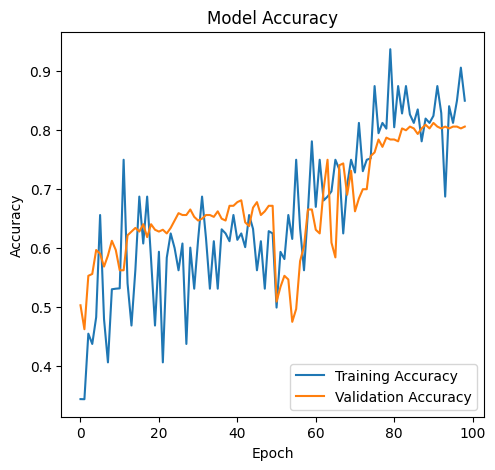

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Training Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('training_history_accuarcy.png')
plt.legend(loc='lower right')

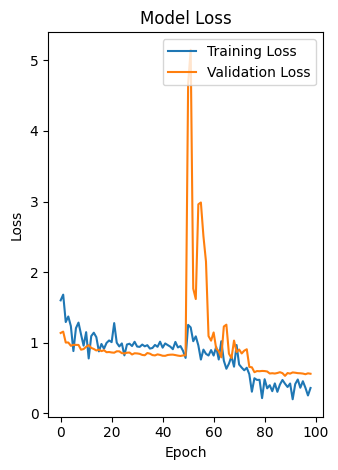

In [ ]:
# Plot loss
plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Training Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator, verbose=1)
print("Test Loss:", val_loss)
print("Test Accuracy:", val_accuracy * 100, "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.8203 - loss: 0.4708
Test Loss: 0.5599212050437927
Test Accuracy: 80.30303120613098 %


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict on test data
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get class with highest probability
y_true = np.argmax(y_test, axis=1)        # If y_test is one-hot encoded

# Generate classification report
target_names = ['0Normal', '1Doubtful', '2Mild','3Moderate','4Severe']
print(classification_report(y_true, y_pred, target_names=target_names))


11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step
              precision    recall  f1-score   support

     0Normal       0.85      0.92      0.88       103
   1Doubtful       0.77      0.76      0.76        96
       2Mild       0.68      0.61      0.64        46
   3Moderate       0.91      0.70      0.79        44
     4Severe       0.79      0.93      0.85        41

    accuracy                           0.80       330
   macro avg       0.80      0.78      0.79       330
weighted avg       0.80      0.80      0.80       330



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


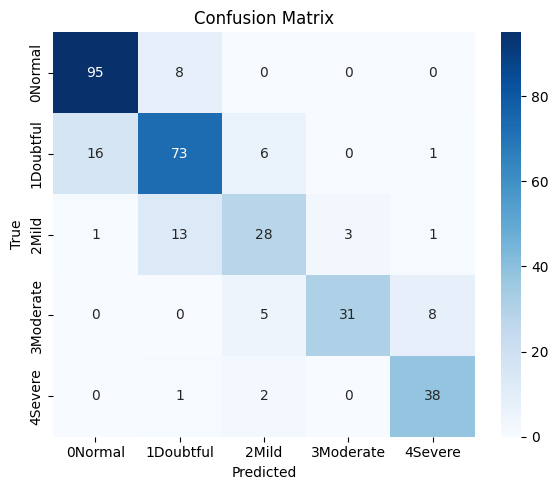

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)  # if one-hot encoded

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['0Normal', '1Doubtful', '2Mild','3Moderate','4Severe']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


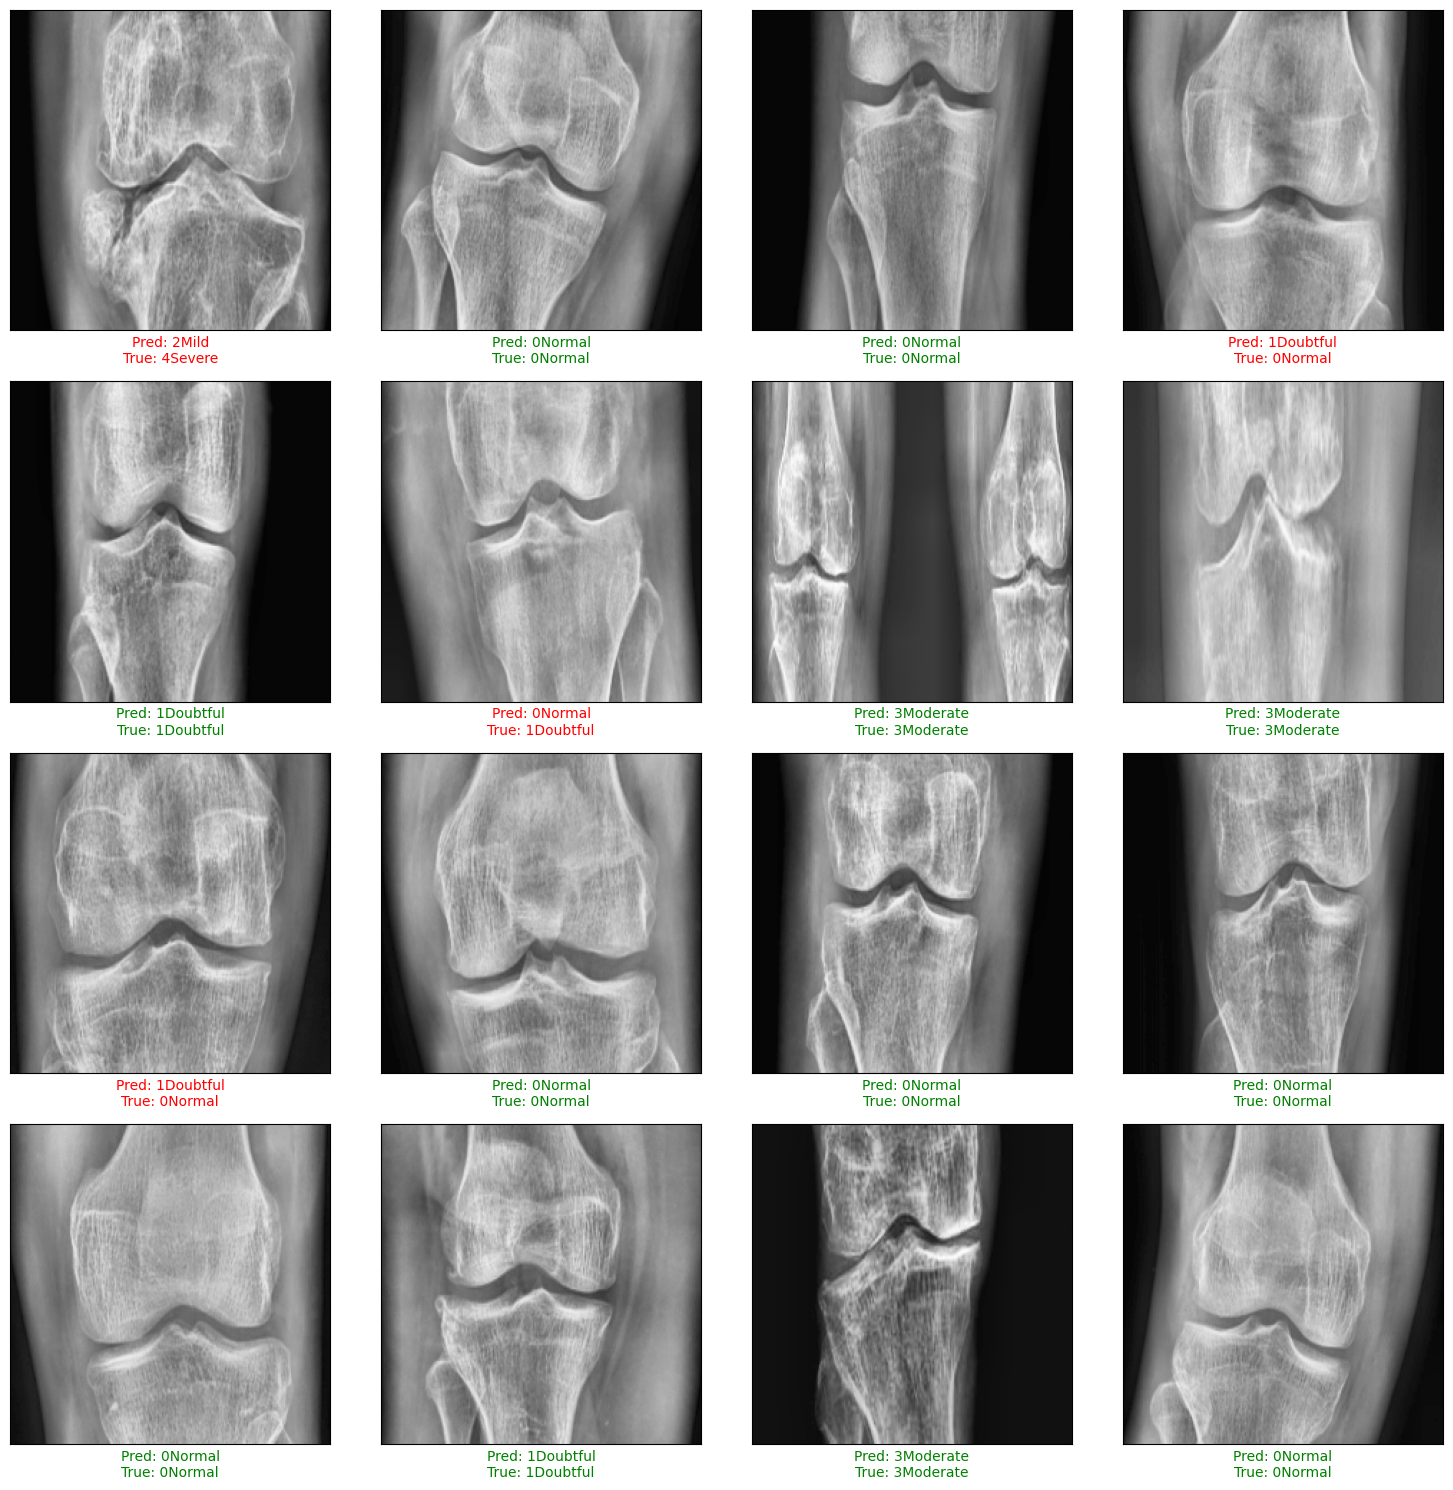

In [ ]:
# Make predictions on test data
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
# Visualize some predictions
plt.figure(figsize=(15, 15))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    pred_label = categories[predicted_classes[i]]
    true_label = categories[true_classes[i]]
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    plt.xlabel(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
plt.tight_layout()
plt.savefig('prediction_samples.png')
plt.show()